In [18]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import h5py

from tqdm.auto import tqdm
import warnings
warnings.filterwarnings('ignore')

import matplotlib
import matplotlib.pyplot as plt

from plotting import *
from pinn import *
from train_PINN import *

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Sociohydrodynamics PINNS


$$ \dot{\phi}_i = \nabla \cdot \bigg( D_{ij} \nabla \phi_j  - \Gamma_i \phi_i \big(1 - \sum_j \phi_j \big) \nabla^3 \phi_i \bigg) $$
$$ D_{ij} = c^0_{ij} + c^1_{ij} \phi_A + c^2_{ij} \phi_B + c^3_{ij} \phi_A^2 + c^4_{ij} \phi_B^2 + c^5_{ij} \phi_A \phi_B $$

## Load data

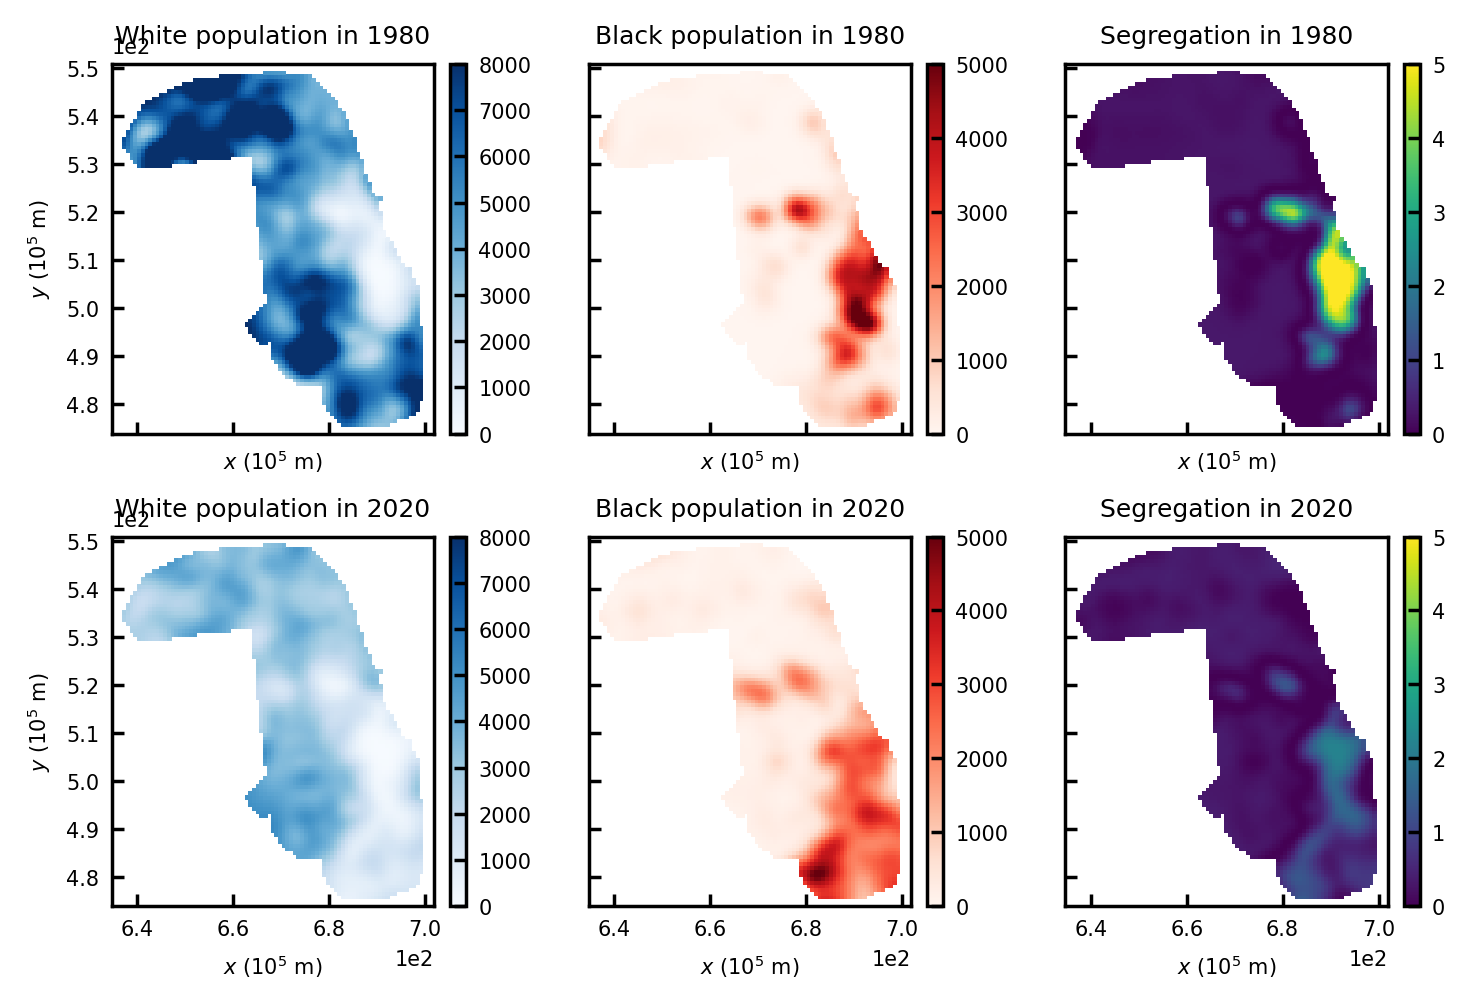

In [19]:
'''
Load and plot data from HDF5 files 
'''
with h5py.File("../data/cook_IL.hdf5", "r") as d:
    x_grid = d["x_grid"][:] / 1e3
    y_grid = d["y_grid"][:] / 1e3
    w_grid = d["w_grid_array_masked"][:].transpose(2, 0, 1)
    b_grid = d["b_grid_array_masked"][:].transpose(2, 0, 1)
    
    for ii in range(w_grid.shape[0]):
        w_grid[ii] = smooth_with_fill(w_grid[ii], sigma=2)
        b_grid[ii] = smooth_with_fill(b_grid[ii], sigma=2)
        
    max_grid = (w_grid + b_grid).max(axis=0) * 1.1
    w_grid /= max_grid
    b_grid /= max_grid
                
T = np.array([1980, 1990, 2000, 2010, 2020])

fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)

kwargs = dict(x_grid=x_grid, y_grid=y_grid, wmax=8000, bmax=5000, smax=5, max_grid=max_grid)

ii = 0
plot_white_black_seg(fig, ax[0], w_grid[ii], b_grid[ii], T[ii], **kwargs)

ii = 4
plot_white_black_seg(fig, ax[1], w_grid[ii], b_grid[ii], T[ii], **kwargs)

plt.tight_layout()

(100, 87) (100, 87) (5, 100, 87) (5, 100, 87) (5, 100, 87)
(19005,) (19005,) (19005,) (19005,) (19005,)
(1000,) (1000,) (1000,) (1000,) (1000,)


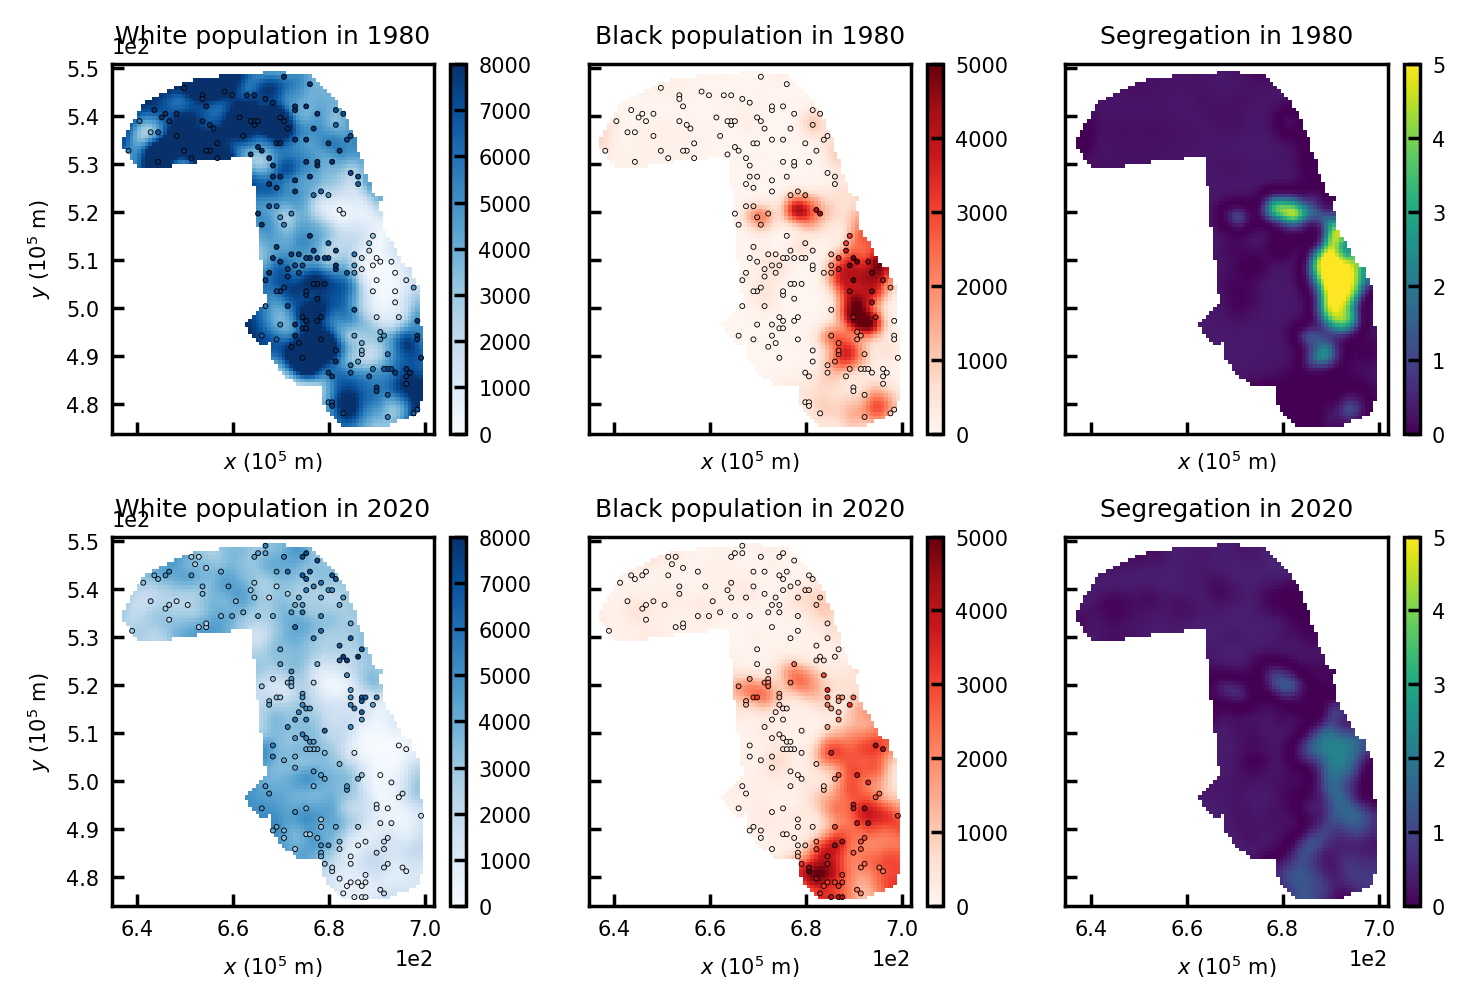

In [20]:
#Convert points from YX grid to TYX list
x = np.tile(x_grid[None], (len(T), 1, 1))
y = np.tile(y_grid[None], (len(T), 1, 1))
t = np.tile(T[:, None, None], (1, *x_grid.shape))

print(x_grid.shape, y_grid.shape, t.shape, w_grid.shape, b_grid.shape)

#Remove any points where there are NaNs
keep = np.logical_and(~np.isnan(w_grid), ~np.isnan(b_grid))
w = w_grid[keep]
b = b_grid[keep]
t = t[keep]
y = y[keep]
x = x[keep]

print(x.shape, y.shape, t.shape, w.shape, b.shape)

#Select points for reconstruction loss
idx = np.random.choice(np.prod(x.shape), 1000, replace=False)

x_u = x[idx]
y_u = y[idx]
t_u = t[idx]
w_u = w[idx]
b_u = b[idx]

print(x_u.shape, y_u.shape, t_u.shape, w_u.shape, b_u.shape)

margs = [
    torch.from_numpy(x_u).float(),
    torch.from_numpy(y_u).float(),
    torch.from_numpy(t_u).float(),
    torch.from_numpy(w_u).float(),
    torch.from_numpy(b_u).float(),
]

#plot points
fig, ax = plt.subplots(2, 3, sharey=True, sharex=True)

kwargs = dict(x_grid=x_grid, y_grid=y_grid, wmax=8000, bmax=5000, smax=5, max_grid=max_grid)
swargs = dict(s=2, vmin=0, alpha=1, edgecolor='black', linewidths=0.25)

ii = 0
plot_white_black_seg(fig, ax[0], w_grid[ii], b_grid[ii], T[ii], **kwargs)

msk = t_u == T[ii]
ax[0, 0].scatter(x_u[msk], y_u[msk], c=w_u[msk], **swargs, cmap='Blues')
ax[0, 1].scatter(x_u[msk], y_u[msk], c=b_u[msk], **swargs, cmap='Reds')

ii = 4
plot_white_black_seg(fig, ax[1], w_grid[ii], b_grid[ii], T[ii], **kwargs)

msk = t_u == T[ii]
ax[1, 0].scatter(x_u[msk], y_u[msk], c=w_u[msk], **swargs, cmap='Blues')
ax[1, 1].scatter(x_u[msk], y_u[msk], c=b_u[msk], **swargs, cmap='Reds')

plt.tight_layout()

## Plotting PINN results

[3, 256, 256, 256, 256, 256, 6]
[3, 256, 256, 256, 256, 256, 6]
(19005, 2) (19005, 4)
SymmetricCrossDiffusionPINN Iter = 40000	Loss = 2.940e-03, MSE = 2.882e-03, Phys = 5.854e-05
  dt P_a = div( D_aa grad(P_a) + D_+ grad(P_b))
  dt P_b = div( D_bb grad(P_b) + D_+ grad(P_b))



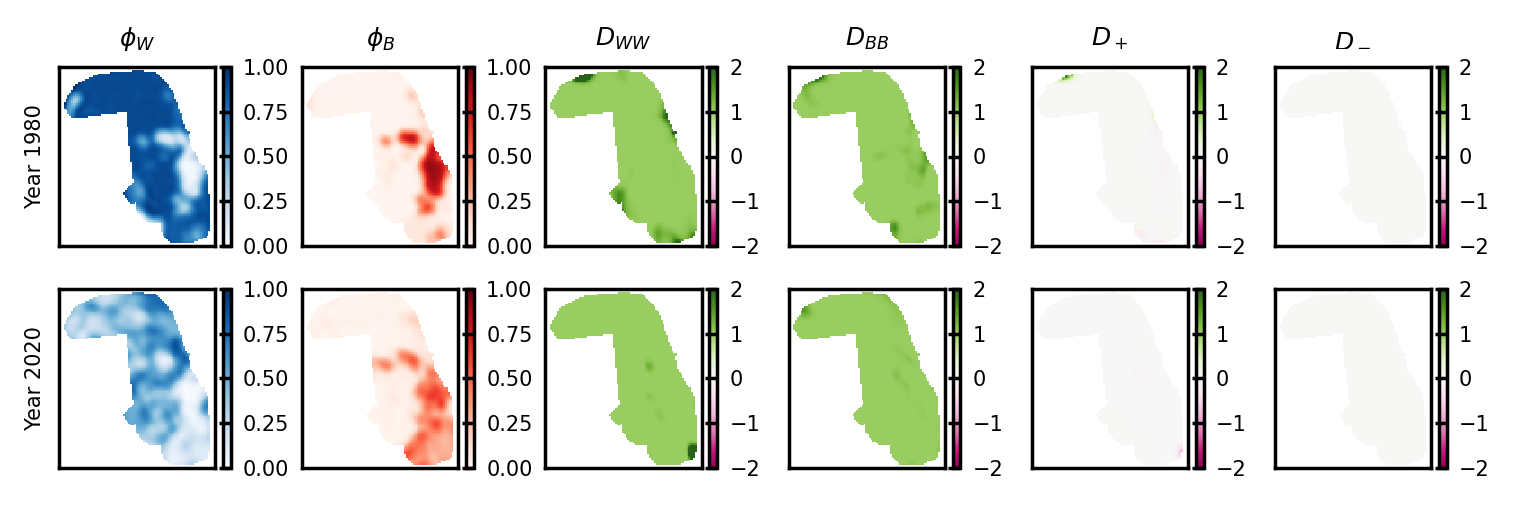

In [32]:
from pinn import *

lw = 1
plt.rcParams['axes.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.linewidth'] = lw
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.major.width'] = lw
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.major.width'] = lw
plt.rcParams['font.size'] = 6
plt.rcParams['legend.framealpha'] = 0.
plt.rcParams['legend.handlelength'] = 1.25
plt.rcParams['image.origin'] = 'upper'
plt.rcParams['pcolor.shading'] = 'auto'
plt.rcParams['figure.dpi'] = 250

def plot_white_black_Dij(fig, ax, w_grid, b_grid, D_grid, year, x_grid, y_grid, vmax=2, title=False):
    
    c0 = ax[0].pcolormesh(x_grid, y_grid, w_grid, cmap="Blues", vmin=0, vmax=1)
    cax0 = ax[0].inset_axes([1.05, 0, 0.05, 1])
    fig.colorbar(c0, ax=ax[0], cax=cax0)

    c1 = ax[1].pcolormesh(x_grid, y_grid, b_grid, cmap="Reds", vmin=0, vmax=1)
    cax1 = ax[1].inset_axes([1.05, 0, 0.05, 1])
    fig.colorbar(c1, ax=ax[1], cax=cax1)

    if title:
        ax[0].set_title(f'$\\phi_W$')
        ax[1].set_title(f'$\\phi_B$')
        
    toplot = {
        '$D_{WW}$': np.exp(D_grid[..., 0]),
        '$D_{BB}$': np.exp(D_grid[..., 3]),
        '$D_+$': 0.5 * (D_grid[..., 1] + D_grid[..., 2]),
        '$D_-$': 0.5 * (D_grid[..., 1] - D_grid[..., 2]),
    }
    
    for i, key in enumerate(toplot.keys()):
        ci = ax[i+2].pcolormesh(x_grid, y_grid, toplot[key],
                                cmap='PiYG', vmin=-vmax, vmax=vmax)
        if title:
            ax[i+2].set_title(key)
        caxi = ax[i+2].inset_axes([1.05, 0, 0.05, 1])
        fig.colorbar(ci, ax=ax[i+2], cax=caxi)
    
    for a in ax.ravel():
        a.set_aspect(1)
        a.set(xticks=[], yticks=[])

def plot(model):
    tyx = np.stack([t, y, x], axis=-1)
    tyx = torch.from_numpy(tyx).float().to(device)
    with torch.no_grad():
        wbD = model(tyx)
        wb = wbD[:, :2].cpu().numpy()
        D =  model.get_diffusion(wbD[:, 2:]).cpu().numpy()
        print(wb.shape, D.shape)

    w_pred = np.zeros_like(w_grid)
    b_pred = np.zeros_like(b_grid)
    D_pred = np.zeros([*w_grid.shape, 4])

    w_pred[keep] = wb[:, 0]
    w_pred[~keep] = np.nan

    b_pred[keep] = wb[:, 1]
    b_pred[~keep] = np.nan

    D_pred[keep] = D
    D_pred[~keep] = np.nan
    
    #plot points
    fig, ax = plt.subplots(2, 6, figsize=(6, 2), sharey=True, sharex=True)

    ii = 0
    plot_white_black_Dij(fig, ax[0], w_pred[ii], b_pred[ii], D_pred[ii], T[ii], x_grid, y_grid, title=True)
    ax[0,0].set_ylabel(f'Year {T[ii]}')

    ii = 4
    plot_white_black_Dij(fig, ax[1], w_pred[ii], b_pred[ii], D_pred[ii], T[ii], x_grid, y_grid)
    ax[1,0].set_ylabel(f'Year {T[ii]}')

    plt.tight_layout()


modeltype = SymmetricCrossDiffusionPINN
model = modeltype(*margs).to(device)#, **info['hparams']).to(device)
info = torch.load(f'./{modeltype.__name__}', map_location='cpu')
model = modeltype(*margs).to(device)#, **info['hparams']).to(device)
model.model.load_state_dict(info['state_dict'])
model.iter = info['iteration']
plot(model)
model.print()

## Sociohydrodynamics PINN


$$ \dot{\phi}_i = \nabla \cdot \bigg( D_{ij} \nabla \phi_j  - \Gamma_i \phi_i \big(1 - \sum_j \phi_j \big) \nabla^3 \phi_i \bigg) $$
$$ D_{ij} = c^0_{ij} + c^1_{ij} \phi_A + c^2_{ij} \phi_B + c^3_{ij} \phi_A^2 + c^4_{ij} \phi_B^2 + c^5_{ij} \phi_A \phi_B $$

# Verify on Burgers

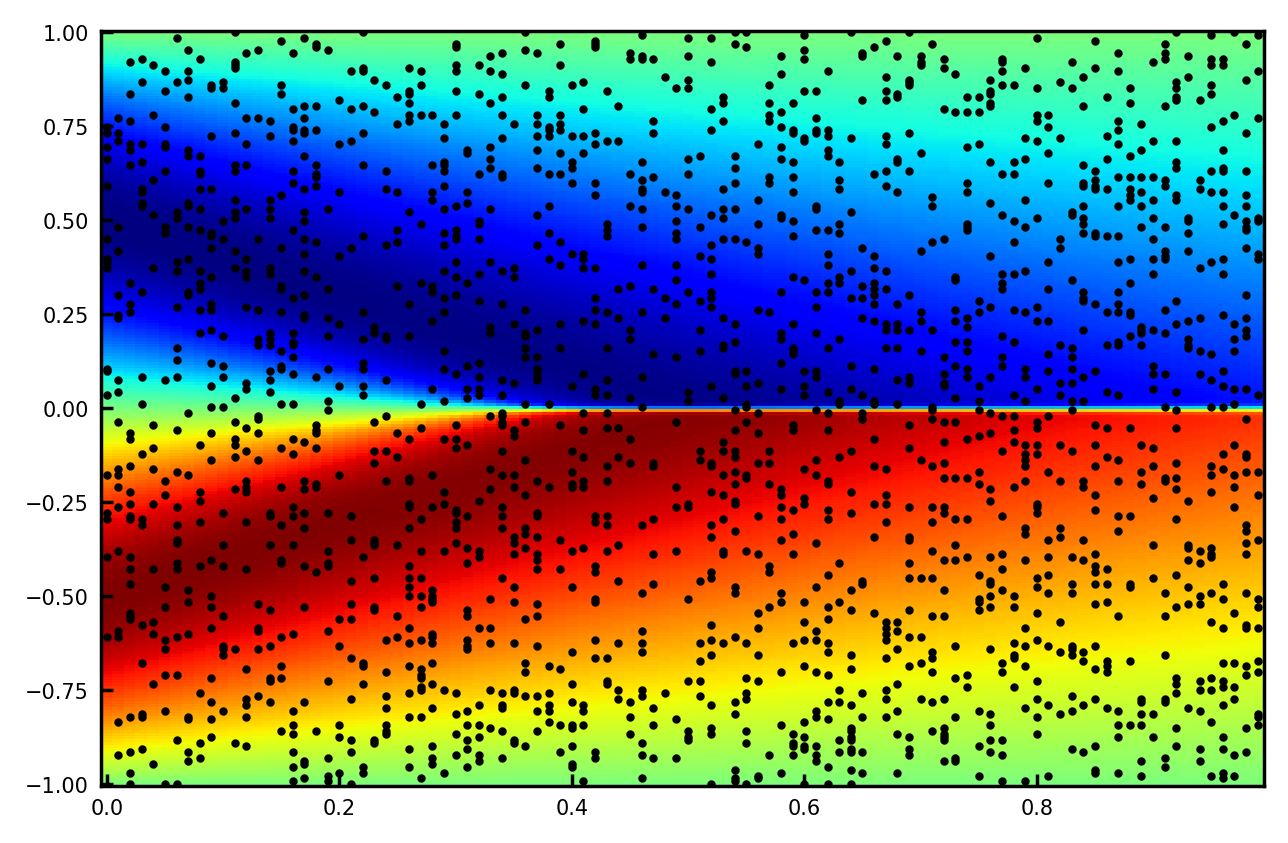

In [75]:
from scipy.io import loadmat
import numpy as np

data = loadmat('../gfnn/Burgers/data/burgers_shock.mat')

U_star = data['usol']
t_star = data['t']
X_star = data['x']

N = X_star.shape[0]
T = t_star.shape[0]

# Rearrange Data 
XX = np.tile(X_star[:,0:1], (1,T)) # N x T
TT = np.tile(t_star, (1,N)).T # N x T

x = XX.flatten()[:,None] # NT x 1
t = TT.flatten()[:,None] # NT x 1
u = U_star.flatten()[:,None] # NT x 1

fig, ax = plt.subplots(1, 1)
ax.pcolormesh(TT, XX, U_star, cmap='jet')

idx = np.random.choice(N*T, 2000, replace=False)
x_u = x[idx,:].squeeze()
t_u = t[idx,:].squeeze()
u_u = u[idx, :].squeeze()
ax.scatter(t_u, x_u, color='black', s=2)

In [78]:
from pinn import *

class BurgersPINN(PINN):
    def mse_loss(self, wb_u):
        mse = (wb_u[:, 0:1] - self.w_u).pow(2).mean()
        return mse
    
    def phys_loss(self, wb):
        t, y, x = self.t_u, self.y_u, self.x_u
        w = wb[:, 0:1]
        
        d_w = gradient(w, t, x)
        dt_w = d_w[..., 0:1]
        grad_w = d_w[..., 1:2]
        lapl_w = div(grad_w, x)
                
        lambda_1 = self.coefs[0, 0]
        eta = self.coefs[1, 0].exp()
        
        f_w = dt_w[..., 0] + lambda_1 * w * grad_w[..., 0] - eta * lapl_w
        phys = f_w.pow(2).mean()
        return phys
        
    def equation_string(self):
        coefs = self.coefs[:, 0].detach().cpu().numpy()
        eq =  f'dt P_w + {coefs[0]:.3f} w grad w = {np.exp(coefs[1]):.3f} grad^2 P_w'
        return eq

device = torch.device('cuda:0')
model = BurgersPINN(
    torch.from_numpy(x_u).float(),
    torch.from_numpy(np.ones_like(x_u)).float(),
    torch.from_numpy(t_u).float(),
    torch.from_numpy(u_u).float(),
    torch.from_numpy(np.ones_like(u_u)).float(),
    N_h=50,
    N_l=4,
    lbfgs_lr=1e1,
    print_every=1000,
)
model.to(device)

model.train()

[3, 50, 50, 50, 50, 2]
Starting L-BFGS optimization
Loss: 5.398835e-03, MSE: 4.076345e-03, Phys: 1.322490e-03, 
dt P_w + 0.847 w grad w = 0.009 grad^2 P_w

Loss: 1.472725e-03, MSE: 1.035403e-03, Phys: 4.373219e-04, 
dt P_w + 0.954 w grad w = 0.006 grad^2 P_w



KeyboardInterrupt: 

(256, 100) (256, 100)


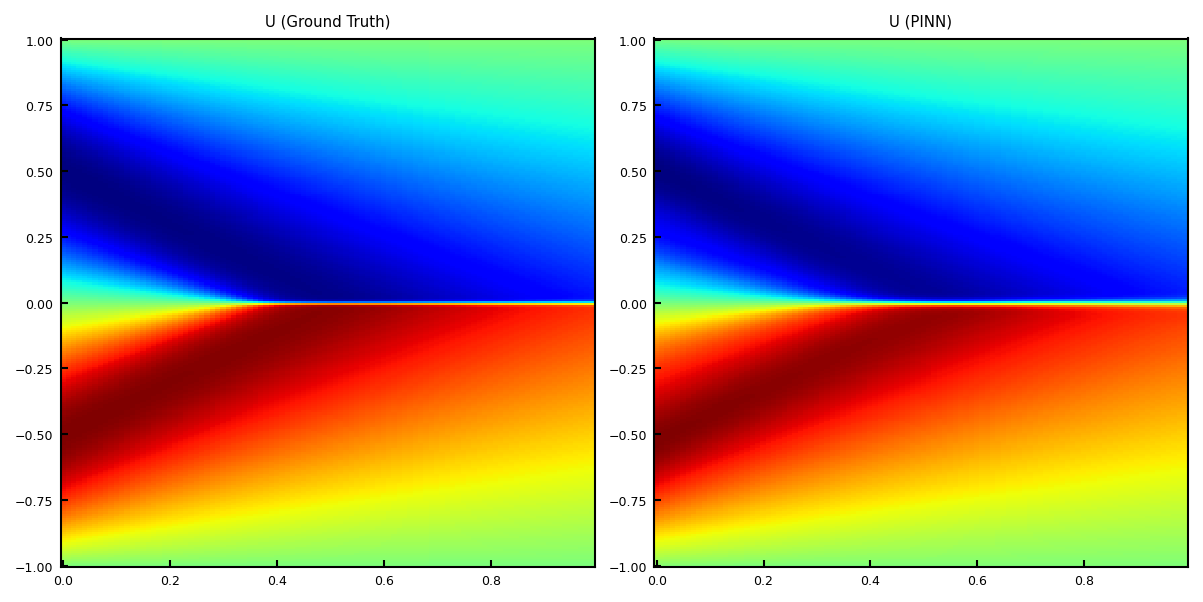

In [79]:
tyx = torch.from_numpy(np.stack([t, np.ones_like(x), x], axis=-1)).float().to(device).squeeze()
preds = model(tyx).detach().cpu().numpy()[:, 0]
u1 = preds.reshape(U_star.shape)
print(U_star.shape, u1.shape)

fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=150)
ax[0].pcolormesh(TT, XX, U_star, cmap='jet')
ax[1].pcolormesh(TT, XX, u1, cmap='jet')

ax[0].set_title('U (Ground Truth)')
ax[1].set_title('U (PINN)')
plt.tight_layout()